In [2]:
import sys
from pathlib import Path

project_root = Path.cwd()
while project_root != project_root.parent and not (project_root / "config").exists():
    project_root = project_root.parent

sys.path.append(str(project_root))

In [3]:
import joblib
import pandas as pd

from config.settings import XGB_MODEL_PATHS, FEATURE_COLUMNS, DATE_COLUMN, TARGET_COLUMN
from src.features.feature_engineer import engineer_features




In [4]:
# загрузка модели на нужный горизонт
model = joblib.load(Path("/Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h168.joblib"))  # или 24, 1


In [19]:
# подготовка данных
df = pd.read_csv("/Users/alice/Desktop/EnergyForecast/Kharovsklesprom_data.csv")

In [20]:
df

,Unnamed: 0,Date,Time,Usage_kWh
0,0,2017-01-01,00 - 01,570.685479
1,1,2017-01-01,01 - 02,604.642705
2,2,2017-01-01,02 - 03,518.732113
3,3,2017-01-01,03 - 04,608.188829
4,4,2017-01-01,04 - 05,714.140572
...,...,...,...,...
35059,35059,2020-12-31,19 - 20,1093.896979
35060,35060,2020-12-31,20 - 21,976.242006
35061,35061,2020-12-31,21 - 22,960.551132
35062,35062,2020-12-31,22 - 23,694.074945


In [7]:
from src.data.loader import normalize_data_format, ensure_datetime_column

In [8]:
# нормализация как в приложении

df = normalize_data_format(df)
df = ensure_datetime_column(df, DATE_COLUMN).sort_values(DATE_COLUMN)

feat_df = engineer_features(df, DATE_COLUMN, TARGET_COLUMN)
X = feat_df[FEATURE_COLUMNS]

y_pred = model.predict(X)

In [12]:
y_pred


array([1153.19375261, 1153.19375261, 1151.63570873, ..., 1115.41905711,
       1132.31295968, 1078.90076735], shape=(2000,))

In [31]:
import sys
from pathlib import Path
import pandas as pd

project_root = Path.cwd()
while project_root != project_root.parent and not (project_root / "src").exists():
    project_root = project_root.parent
sys.path.append(str(project_root))

from src.data.loader import normalize_data_format, ensure_datetime_column
from src.data.feature_builder import build_features_X_optimized, build_targets_multi_horizon, time_split_Xy

DATE_COLUMN = "datetime"
TARGET_COLUMN = "Usage_kWh"

path = "/Users/alice/Downloads/Kharovsklesprom_2000.csv"
df = pd.read_csv(path)
df = normalize_data_format(df)
df = ensure_datetime_column(df, DATE_COLUMN).sort_values(DATE_COLUMN)

X, y = build_features_X_optimized(df.set_index(DATE_COLUMN), target_col=TARGET_COLUMN)
targets = build_targets_multi_horizon(y, horizons=(1, 24, 168))

splits = {}
for h in (1, 24, 168):
    mask = targets[h]["mask"]
    X_h = X.loc[mask]
    y_h = targets[h]["y"].loc[mask]
    splits[h] = time_split_Xy(X_h, y_h)


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred, eps=1e-8):
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denom)

def eval_saved_xgb_models(splits, model_paths, horizons=(1, 24, 168)):
    rows = {}
    for h in horizons:
        if h not in splits:
            raise KeyError(f"splits не содержит h={h}")
        if h not in model_paths:
            raise KeyError(f"model_paths не содержит h={h}")

        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = joblib.load(model_paths[h])
        y_pred_test = model.predict(X_test)

        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        test_smape = smape(y_test.values, y_pred_test)
        bias = (y_test, y_pred_test).mean()

        rows[h] = {
            "model": "XGBoost_saved",
            "horizon": int(h),
            "test_MAE": float(test_mae),
            "test_RMSE": float(test_rmse),
            "test_sMAPE_pct": float(test_smape),
            "n_train": int(len(X_train)),
            "n_val": int(len(X_val)),
            "n_test": int(len(X_test)),
            "bias": float(bias)}

        print(
            f"[SAVED XGB] h={h}: "
            f"test_MAE={test_mae:.2f}, test_RMSE={test_rmse:.2f}, test_sMAPE={test_smape:.2f}%"
        )

    summary_df = (
        pd.DataFrame(list(rows.values()))
        .sort_values("horizon")
        .reset_index(drop=True)
    )
    return summary_df

# пример вызова
from config.settings import XGB_MODEL_PATHS
saved_summary = eval_saved_xgb_models(splits, XGB_MODEL_PATHS)
saved_summary


AttributeError: 'tuple' object has no attribute 'mean'

In [57]:
bias = (y_test, y_pred_test).mean()
print("bias:", bias)

NameError: name 'y_test' is not defined

In [61]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denom)

def eval_saved_xgb_models(splits, model_paths, horizons=(1, 24, 168)):
    rows = {}
    for h in horizons:
        if h not in splits:
            raise KeyError(f"splits не содержит h={h}")
        if h not in model_paths:
            raise KeyError(f"model_paths не содержит h={h}")

        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = joblib.load(model_paths[h])
        y_pred_test = model.predict(X_test)

        y_true = np.asarray(y_test)
        y_pred = np.asarray(y_pred_test)

        test_mae = mean_absolute_error(y_true, y_pred)
        test_rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
        test_smape = smape(y_true, y_pred)
        bias = float((y_pred - y_true).mean())

        rows[h] = {
            "model": "XGBoost_saved",
            "horizon": int(h),
            "test_MAE": float(test_mae),
            "test_RMSE": float(test_rmse),
            "test_sMAPE_pct": float(test_smape),
            "bias": bias,
            "n_train": int(len(X_train)),
            "n_val": int(len(X_val)),
            "n_test": int(len(X_test)),
        }

        print(
            f"[SAVED XGB] h={h}: "
            f"test_MAE={test_mae:.2f}, test_RMSE={test_rmse:.2f}, "
            f"test_sMAPE={test_smape:.2f}%, bias={bias:.2f}"
        )

    summary_df = (
        pd.DataFrame(list(rows.values()))
        .sort_values("horizon")
        .reset_index(drop=True)
    )
    return summary_df



saved_summary = eval_saved_xgb_models(splits, XGB_MODEL_PATHS)
saved_summary

[SAVED XGB] h=1: test_MAE=84.59, test_RMSE=114.92, test_sMAPE=9.66%, bias=2.96
[SAVED XGB] h=24: test_MAE=114.13, test_RMSE=148.89, test_sMAPE=12.52%, bias=-59.91
[SAVED XGB] h=168: test_MAE=96.19, test_RMSE=129.03, test_sMAPE=10.60%, bias=-8.88


,model,horizon,test_MAE,test_RMSE,test_sMAPE_pct,bias,n_train,n_val,n_test
0,XGBoost_saved,1,84.586885,114.923542,9.657180,2.958474,1281,274,276
1,XGBoost_saved,24,114.125966,148.889582,12.518125,-59.914148,1265,271,272
2,XGBoost_saved,168,96.192887,129.031018,10.595595,-8.877061,1164,249,251


In [79]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denom)

def evaluate_and_show_points_h168(
    splits: dict,
    model_paths: dict,
    date_index_name: str = None,   # можно оставить None
    n_points: int = 168,           # сколько точек показать (например 168 или 500)
    start_idx: int = None          # можно задать, чтобы смотреть "с середины" теста
):
    """
    1) Считает метрики для сохранённой XGB модели h=168 на X_test/y_test.
    2) Возвращает DataFrame с точками (origin_time -> forecast_time) и факт/прогноз.

    Предположение: y_test индексирован временем (DatetimeIndex) — как у вас в time_split_Xy.
    """

    h = 168
    if h not in splits:
        raise KeyError("splits не содержит h=168")
    if h not in model_paths:
        raise KeyError("model_paths не содержит путь для h=168")

    X_train, y_train, X_val, y_val, X_test, y_test = splits[h]
    print(X_test)
    print(y_test)

    # --- модель и прогноз по всему тесту ---
    model = joblib.load(model_paths[h])
    y_pred_test = model.predict(X_test)

    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_pred_test)

    test_mae = mean_absolute_error(y_true, y_pred)
    test_rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    test_smape = smape(y_true, y_pred)
    bias = float((y_pred - y_true).mean())

    print(
        f"[SAVED XGB] h=168: "
        f"test_MAE={test_mae:.2f}, test_RMSE={test_rmse:.2f}, "
        f"test_sMAPE={test_smape:.2f}%, bias={bias:.2f}"
    )

    # --- подготовка таблицы "точек" ---
    # Если индекс y_test - это время, то это forecast_time (t+h)
    if not hasattr(y_test, "index"):
        raise ValueError("y_test должен быть pandas Series с индексом времени")

    forecast_time = pd.to_datetime(y_test.index)

    # origin_time = forecast_time - h часов (тот t, из которого были признаки)
    origin_time = forecast_time - pd.Timedelta(hours=h)

    points = pd.DataFrame({
        "origin_time": origin_time,
        "forecast_time": forecast_time,
        "y_true": y_test.values,
        "y_pred": y_pred_test,
    })
    points["error"] = points["y_pred"] - points["y_true"]
    points["abs_error"] = points["error"].abs()

    # --- выбрать подвыборку для просмотра ---
    if n_points is not None:
        n_points = int(n_points)
        if n_points <= 0:
            raise ValueError("n_points должен быть > 0")

        if start_idx is None:
            # по умолчанию показываем последние n_points (часто удобнее)
            points_view = points.tail(n_points).copy()
        else:
            start_idx = int(start_idx)
            points_view = points.iloc[start_idx:start_idx + n_points].copy()
    else:
        points_view = points.copy()

    # базовые диапазоны (чтобы быстро увидеть "сжатие")
    print("y_true min/max (view):", float(points_view["y_true"].min()), float(points_view["y_true"].max()))
    print("y_pred min/max (view):", float(points_view["y_pred"].min()), float(points_view["y_pred"].max()))

    return {
        "metrics": {
            "horizon": 168,
            "MAE": float(test_mae),
            "RMSE": float(test_rmse),
            "sMAPE_pct": float(test_smape),
            "bias": float(bias),
            "n_test": int(len(X_test)),
        },
        "points_all": points,
        "points_view": points_view,
    }

# --- пример вызова ---
# from config.settings import XGB_MODEL_PATHS
res = evaluate_and_show_points_h168(
    splits=splits,
    model_paths=XGB_MODEL_PATHS,
    n_points=168  # посмотреть 168 точек
)

points_168 = res["points_view"]
points_168.head(10)

                     month  day_of_week  hour  is_weekend  day_of_year  \
datetime                                                                 
2020-12-14 13:00:00     12            0    13           0          349   
2020-12-14 14:00:00     12            0    14           0          349   
2020-12-14 15:00:00     12            0    15           0          349   
2020-12-14 16:00:00     12            0    16           0          349   
2020-12-14 17:00:00     12            0    17           0          349   
...                    ...          ...   ...         ...          ...   
2020-12-24 19:00:00     12            3    19           0          359   
2020-12-24 20:00:00     12            3    20           0          359   
2020-12-24 21:00:00     12            3    21           0          359   
2020-12-24 22:00:00     12            3    22           0          359   
2020-12-24 23:00:00     12            3    23           0          359   

                           lag_1     

,origin_time,forecast_time,y_true,y_pred,error,abs_error
83,2020-12-11 00:00:00,2020-12-18 00:00:00,498.574066,501.713462,3.139396,3.139396
84,2020-12-11 01:00:00,2020-12-18 01:00:00,448.325928,554.408349,106.082421,106.082421
85,2020-12-11 02:00:00,2020-12-18 02:00:00,589.959778,559.400715,-30.559063,30.559063
86,2020-12-11 03:00:00,2020-12-18 03:00:00,408.063416,553.509179,145.445764,145.445764
87,2020-12-11 04:00:00,2020-12-18 04:00:00,406.263062,557.745102,151.482041,151.482041
88,2020-12-11 05:00:00,2020-12-18 05:00:00,537.177429,563.330843,26.153414,26.153414
89,2020-12-11 06:00:00,2020-12-18 06:00:00,654.075989,677.567260,23.491271,23.491271
90,2020-12-11 07:00:00,2020-12-18 07:00:00,1280.054199,1215.917896,-64.136303,64.136303
91,2020-12-11 08:00:00,2020-12-18 08:00:00,1313.431030,1328.004860,14.573830,14.573830
92,2020-12-11 09:00:00,2020-12-18 09:00:00,1069.302612,1321.436648,252.134035,252.134035


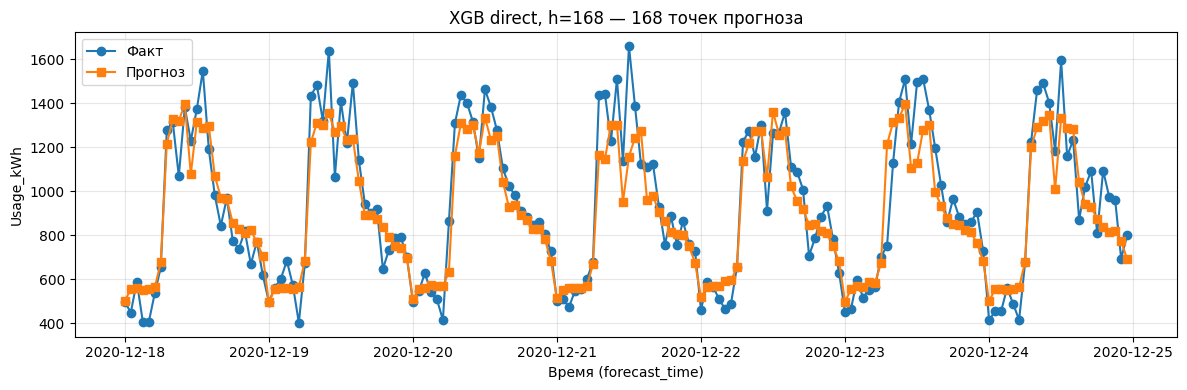

In [71]:
import matplotlib.pyplot as plt

def plot_points(points_df, title="h=168: факт vs прогноз"):
    dfp = points_df.sort_values("forecast_time")
    plt.figure(figsize=(12, 4))
    plt.plot(dfp["forecast_time"], dfp["y_true"], label="Факт", marker="o")
    plt.plot(dfp["forecast_time"], dfp["y_pred"], label="Прогноз", marker="s")
    plt.title(title)
    plt.xlabel("Время (forecast_time)")
    plt.ylabel("Usage_kWh")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_points(points_168, title="XGB direct, h=168 — 168 точек прогноза")

In [80]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

# чтобы видеть src/config (как у вас)
project_root = Path.cwd()
while project_root != project_root.parent and not (project_root / "src").exists():
    project_root = project_root.parent
sys.path.append(str(project_root))

from config.settings import FEATURE_COLUMNS, DATE_COLUMN, TARGET_COLUMN, XGB_MODEL_PATHS
from src.data.loader import normalize_data_format, ensure_datetime_column
from src.data.feature_builder import build_features_X_optimized

def forecast_future_rolling_direct(
    data_path: str,
    horizon: int = 168,
    n_points: int = 168,
):
    """
    Строит прогноз на будущее от конца датасета:
    Берёт последние n_points origin-моментов t и для каждого прогнозирует t+horizon.
    Возвращает DataFrame: origin_time, forecast_time, forecast.
    """
    horizon = int(horizon)
    n_points = int(n_points)

    if horizon not in XGB_MODEL_PATHS:
        raise KeyError(f"В XGB_MODEL_PATHS нет модели для horizon={horizon}")

    # --- загрузка данных ---
    df = pd.read_csv(data_path)
    df = normalize_data_format(df)
    df = ensure_datetime_column(df, DATE_COLUMN).sort_values(DATE_COLUMN)

    # build_features_X_optimized требует datetime-index
    df_idx = df.set_index(DATE_COLUMN)

    # --- признаки (как при обучении) ---
    X_all, _ = build_features_X_optimized(df_idx, target_col=TARGET_COLUMN)
    print(X_all)

    if len(X_all) < n_points:
        raise ValueError(f"Недостаточно строк с признаками: нужно >= {n_points}, есть {len(X_all)}")

    X_tail = X_all.tail(n_points).copy()

    # защита: порядок колонок ровно как FEATURE_COLUMNS
    X_tail = X_tail[FEATURE_COLUMNS]
    print(X_tail)

    # --- модель ---
    model = joblib.load(XGB_MODEL_PATHS[horizon])
    y_pred = model.predict(X_tail)

    # времена
    origin_time = pd.to_datetime(X_tail.index)               # t
    forecast_time = origin_time + pd.Timedelta(hours=horizon)  # t+h

    out = pd.DataFrame({
        "origin_time": origin_time,
        "forecast_time": forecast_time,
        "forecast": y_pred
    }).reset_index(drop=True)

    return out

# пример вызова:
pred_168 = forecast_future_rolling_direct(
    data_path="/Users/alice/Downloads/Kharovsklesprom_2000.csv",
    horizon=168,
    n_points=168
)

pred_168.head(10), pred_168.tail(10)

                     month  day_of_week  hour  is_weekend  day_of_year  \
datetime                                                                 
2020-10-16 16:00:00     10            4    16           0          290   
2020-10-16 17:00:00     10            4    17           0          290   
2020-10-16 18:00:00     10            4    18           0          290   
2020-10-16 19:00:00     10            4    19           0          290   
2020-10-16 20:00:00     10            4    20           0          290   
...                    ...          ...   ...         ...          ...   
2020-12-31 19:00:00     12            3    19           0          366   
2020-12-31 20:00:00     12            3    20           0          366   
2020-12-31 21:00:00     12            3    21           0          366   
2020-12-31 22:00:00     12            3    22           0          366   
2020-12-31 23:00:00     12            3    23           0          366   

                           lag_1     

(          origin_time       forecast_time     forecast
 0 2020-12-25 00:00:00 2021-01-01 00:00:00  1083.893534
 1 2020-12-25 01:00:00 2021-01-01 01:00:00  1090.701010
 2 2020-12-25 02:00:00 2021-01-01 02:00:00  1120.527129
 3 2020-12-25 03:00:00 2021-01-01 03:00:00  1115.070418
 4 2020-12-25 04:00:00 2021-01-01 04:00:00  1110.336945
 5 2020-12-25 05:00:00 2021-01-01 05:00:00  1109.493690
 6 2020-12-25 06:00:00 2021-01-01 06:00:00  1116.853197
 7 2020-12-25 07:00:00 2021-01-01 07:00:00  1257.732732
 8 2020-12-25 08:00:00 2021-01-01 08:00:00  1366.224101
 9 2020-12-25 09:00:00 2021-01-01 09:00:00  1378.944160,
             origin_time       forecast_time     forecast
 158 2020-12-31 14:00:00 2021-01-07 14:00:00  1397.829694
 159 2020-12-31 15:00:00 2021-01-07 15:00:00  1298.344369
 160 2020-12-31 16:00:00 2021-01-07 16:00:00  1279.848182
 161 2020-12-31 17:00:00 2021-01-07 17:00:00  1178.739989
 162 2020-12-31 18:00:00 2021-01-07 18:00:00  1135.791371
 163 2020-12-31 19:00:00 2021-01-07

In [73]:
# допустим у вас уже есть df с datetime и Usage_kWh
win_start = pd.Timestamp("2020-12-18 00:00:00")
win_end   = pd.Timestamp("2020-12-25 00:00:00")  # неделя

mask = (df[DATE_COLUMN] >= win_start) & (df[DATE_COLUMN] < win_end)
print("true min/max that week:", df.loc[mask, TARGET_COLUMN].min(), df.loc[mask, TARGET_COLUMN].max())

true min/max that week: 343.67141952466415 1670.814825971004


In [78]:
df_sorted = df.sort_values(DATE_COLUMN)
last168 = df_sorted.tail(168)

print("last 168h true min/max:", last168[TARGET_COLUMN].min(), last168[TARGET_COLUMN].max())
print("last date:", df_sorted[DATE_COLUMN].max())

last 168h true min/max: 402.4662126089794 1659.7697015439185
last date: 2020-12-31 23:00:00


In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from src.data.data_manager import DataManager
from src.data.feature_builder import build_targets_multi_horizon, time_split_Xy

dm = DataManager()
X, y = dm.get_ml_features_view()

 View 'ml_features' загружена из кеша: X.shape=(34896, 34)


In [88]:
X = X.tail(2000)

In [89]:
X

,month,day_of_week,hour,is_weekend,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_48,lag_168,rolling_mean_24,rolling_std_24,time_idx
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-10-09 16:00:00,10,4,16,0,283,1142.092651,1151.307739,1179.536011,1543.152710,984.564026,...,778.861389,662.301147,901.305237,999.211792,1122.108643,1165.356323,882.204163,910.992432,355.563812,33064
2020-10-09 17:00:00,10,4,17,0,283,895.522461,1142.092651,1151.307739,1179.536011,1543.152710,...,737.063843,778.861389,662.301147,901.305237,999.211792,820.861084,657.434631,901.551331,352.711182,33065
2020-10-09 18:00:00,10,4,18,0,283,860.576294,895.522461,1142.092651,1151.307739,1179.536011,...,832.327332,737.063843,778.861389,662.301147,901.305237,905.448975,719.920532,895.774841,352.177063,33066
2020-10-09 19:00:00,10,4,19,0,283,825.996216,860.576294,895.522461,1142.092651,1151.307739,...,691.172058,832.327332,737.063843,778.861389,662.301147,975.533020,600.977722,892.636963,352.461029,33067
2020-10-09 20:00:00,10,4,20,0,283,839.812927,825.996216,860.576294,895.522461,1142.092651,...,527.297180,691.172058,832.327332,737.063843,778.861389,1032.117798,565.941833,900.033264,349.265381,33068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,12,3,19,0,366,809.683655,1092.589966,1020.312195,871.449951,1232.714966,...,729.600891,905.476379,861.986267,850.361023,884.348633,787.313782,871.792908,926.830627,363.630951,35059
2020-12-31 20:00:00,12,3,20,0,366,1093.896973,809.683655,1092.589966,1020.312195,871.449951,...,413.102844,729.600891,905.476379,861.986267,850.361023,884.680725,836.013123,935.561829,365.079437,35060
2020-12-31 21:00:00,12,3,21,0,366,976.242004,1093.896973,809.683655,1092.589966,1020.312195,...,455.877991,413.102844,729.600891,905.476379,861.986267,934.859680,849.430542,940.806885,364.706207,35061


In [98]:
from src.data.loader import load_csv, normalize_data_format, ensure_datetime_column
from src.data.validator import validate_dataframe
from src.data.preprocessor import prepare_data_for_forecast
from config.settings import DATE_COLUMN, TARGET_COLUMN

# загрузка (как в app.py)
df = pd.read_csv("/Users/alice/Downloads/Kharovsklesprom_2000.csv")

# нормализация формата
df = normalize_data_format(df)

# приведение даты
df = ensure_datetime_column(df, DATE_COLUMN)

# валидация
is_valid, error_msg = validate_dataframe(
    df, [DATE_COLUMN], DATE_COLUMN, TARGET_COLUMN
)
if not is_valid:
    raise ValueError(error_msg)

# предобработка (как в приложении)
df = prepare_data_for_forecast(df, DATE_COLUMN, TARGET_COLUMN)


In [100]:
X = df.drop(['Unnamed: 0'], axis=1)

In [104]:
X.set_index('datetime', inplace=True)

In [105]:
X

,Usage_kWh
datetime,
2020-10-09 16:00:00,895.522485
2020-10-09 17:00:00,860.576314
2020-10-09 18:00:00,825.996193
2020-10-09 19:00:00,839.812938
2020-10-09 20:00:00,899.452618
...,...
2020-12-31 19:00:00,1093.896979
2020-12-31 20:00:00,976.242006
2020-12-31 21:00:00,960.551132


In [106]:
def forecast_168h(model, X_last: pd.DataFrame) -> list:
    """
    Прогноз на 168 часов вперёд.
    
    Parameters
    ----------
    model : обученная модель для h=168
    X_last : pd.DataFrame
        Признаки для 168 последовательных точек, shape (168, n_features)
    
    Returns
    -------
    list из 168 прогнозных значений
    """
    predictions = model.predict(X_last)
    return predictions.tolist()


# Использование
model_168  = joblib.load('/Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h168.joblib')

# X_last — последние 168 строк твоих данных с признаками
X_last = X.iloc[-168:]  # замени df_features на свой DataFrame с признаками

forecast_list = forecast_168h(model_168, X_last)
print(f"Прогноз на 168 часов: {forecast_list}")

[LightGBM] [Fatal] The number of features in data (1) is not the same as it was in training data (34).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (1) is not the same as it was in training data (34).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [2]:
import joblib
model = joblib.load('/Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h168.joblib')
print(type(model))



<class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
import joblib
import pandas as pd
import numpy as np

# Загрузка модели
model = joblib.load('/Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h168.joblib')  # или путь к твоей модели

# Подготовка входных данных (последнее известное наблюдение с признаками)
# X_input должен содержать те же признаки, на которых обучалась модель
X_input = X

# Прогноз на 168 часов (прямая стратегия - одна модель на каждый горизонт)
predictions = []

for h in range(1, 169):
    model_h = joblib.load(f'model_h{h}.pkl')  # модель для горизонта h
    pred = model_h.predict(X_input)
    predictions.append(pred[0])

# Результат
forecast = pd.Series(predictions, index=range(1, 169), name='forecast')
print(forecast)

FileNotFoundError: [Errno 2] No such file or directory: 'model_h1.pkl'